# Support Vector Machines (SVMs)
*Support vector machines (SVMs)* are a set of supervised learning methods used for classification, regression and outliers detection.

## Advantages of SVMs
* Effective in high dimensional spaces
* Still effective in cases where number of dimensions is greater than the number of samples
* Uses a subset of training points in the decision function (called support vectors), so it is also memory efficient
* Versatile: different Kernel functions can be specified for the decision function

## Disadvantages of SVMs
* If the number of features is much greater than the number of samples, the method is likely to give poor performances.
* SVMs do not directly provide probability estimates, these are calculated using an expensive five-fold cross-validation

*Disclaimer*: Much of the code in this notebook was borrowed from the excellent book [Introduction to Machine Learning with Python](http://shop.oreilly.com/product/0636920030515.do) by Andreas Muller and Sarah Guido.

## Linear SVMs
Linear support vector machines (linear SVMs) are one of the most common linear classification algorithms.  In *scikit-learn*, linear SVMs for classification are implemented in [LinearSVC](http://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html#sklearn.svm.LinearSVC).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [10]:
import numbers
from sklearn.utils import check_array, check_random_state
from sklearn.utils import shuffle as shuffle_

def make_blobs(n_samples=100, n_features=2, centers=2, cluster_std=1.0,
               center_box=(-10.0, 10.0), shuffle=True, random_state=None):
    """Generate isotropic Gaussian blobs for clustering.

    Read more in the :ref:`User Guide <sample_generators>`.

    Parameters
    ----------
    n_samples : int, or tuple, optional (default=100)
        The total number of points equally divided among clusters.

    n_features : int, optional (default=2)
        The number of features for each sample.

    centers : int or array of shape [n_centers, n_features], optional
        (default=3)
        The number of centers to generate, or the fixed center locations.

    cluster_std: float or sequence of floats, optional (default=1.0)
        The standard deviation of the clusters.

    center_box: pair of floats (min, max), optional (default=(-10.0, 10.0))
        The bounding box for each cluster center when centers are
        generated at random.

    shuffle : boolean, optional (default=True)
        Shuffle the samples.

    random_state : int, RandomState instance or None, optional (default=None)
        If int, random_state is the seed used by the random number generator;
        If RandomState instance, random_state is the random number generator;
        If None, the random number generator is the RandomState instance used
        by `np.random`.

    Returns
    -------
    X : array of shape [n_samples, n_features]
        The generated samples.

    y : array of shape [n_samples]
        The integer labels for cluster membership of each sample.

    Examples
    --------
    >>> from sklearn.datasets.samples_generator import make_blobs
    >>> X, y = make_blobs(n_samples=10, centers=3, n_features=2,
    ...                   random_state=0)
    >>> print(X.shape)
    (10, 2)
    >>> y
    array([0, 0, 1, 0, 2, 2, 2, 1, 1, 0])

    See also
    --------
    make_classification: a more intricate variant
    """
    generator = check_random_state(random_state)

    if isinstance(centers, numbers.Integral):
        centers = generator.uniform(center_box[0], center_box[1],
                                    size=(centers, n_features))
    else:
        centers = check_array(centers)
        n_features = centers.shape[1]

    if isinstance(cluster_std, numbers.Real):
        cluster_std = np.ones(len(centers)) * cluster_std

    X = []
    y = []

    n_centers = centers.shape[0]
    if isinstance(n_samples, numbers.Integral):
        n_samples_per_center = [int(n_samples // n_centers)] * n_centers
        for i in range(n_samples % n_centers):
            n_samples_per_center[i] += 1
    else:
        n_samples_per_center = n_samples

    for i, (n, std) in enumerate(zip(n_samples_per_center, cluster_std)):
        X.append(centers[i] + generator.normal(scale=std,
                                               size=(n, n_features)))
        y += [i] * n

    X = np.concatenate(X)
    y = np.array(y)

    if shuffle:
        X, y = shuffle_(X, y, random_state=generator)

    return X, y

In [4]:
def make_forge():
    # a carefully hand-designed dataset lol
    X, y = make_blobs(centers=2, random_state=4, n_samples=30)
    y[np.array([7, 27])] = 0
    mask = np.ones(len(X), dtype=np.bool)
    mask[np.array([0, 1, 5, 26])] = 0
    X, y = X[mask], y[mask]
    return X, y

In [5]:
from matplotlib.colors import ListedColormap
cm2 = ListedColormap(['#0000aa', '#ff2020'])

def plot_2d_separator(classifier, X, fill=False, ax=None, eps=None, alpha=1,
                      cm=cm2, linewidth=None, threshold=None, linestyle="solid"):
    # binary?
    if eps is None:
        eps = X.std() / 2.

    if ax is None:
        ax = plt.gca()

    x_min, x_max = X[:, 0].min() - eps, X[:, 0].max() + eps
    y_min, y_max = X[:, 1].min() - eps, X[:, 1].max() + eps
    xx = np.linspace(x_min, x_max, 100)
    yy = np.linspace(y_min, y_max, 100)

    X1, X2 = np.meshgrid(xx, yy)
    X_grid = np.c_[X1.ravel(), X2.ravel()]
    try:
        decision_values = classifier.decision_function(X_grid)
        levels = [0] if threshold is None else [threshold]
        fill_levels = [decision_values.min()] + levels + [decision_values.max()]
    except AttributeError:
        # no decision_function
        decision_values = classifier.predict_proba(X_grid)[:, 1]
        levels = [.5] if threshold is None else [threshold]
        fill_levels = [0] + levels + [1]
    if fill:
        ax.contourf(X1, X2, decision_values.reshape(X1.shape),
                    levels=fill_levels, alpha=alpha, cmap=cm)
    else:
        ax.contour(X1, X2, decision_values.reshape(X1.shape), levels=levels,
                   colors="black", alpha=alpha, linewidths=linewidth,
                   linestyles=linestyle, zorder=5)

    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks(())
    ax.set_yticks(())

In [6]:
import matplotlib as mpl
from matplotlib.colors import colorConverter

def discrete_scatter(x1, x2, y=None, markers=None, s=10, ax=None,
                     labels=None, padding=.2, alpha=1, c=None, markeredgewidth=None):
    """Adaption of matplotlib.pyplot.scatter to plot classes or clusters.

    Parameters
    ----------

    x1 : nd-array
        input data, first axis

    x2 : nd-array
        input data, second axis

    y : nd-array
        input data, discrete labels

    cmap : colormap
        Colormap to use.

    markers : list of string
        List of markers to use, or None (which defaults to 'o').

    s : int or float
        Size of the marker

    padding : float
        Fraction of the dataset range to use for padding the axes.

    alpha : float
        Alpha value for all points.
    """
    if ax is None:
        ax = plt.gca()

    if y is None:
        y = np.zeros(len(x1))

    unique_y = np.unique(y)

    if markers is None:
        markers = ['o', '^', 'v', 'D', 's', '*', 'p', 'h', 'H', '8', '<', '>'] * 10

    if len(markers) == 1:
        markers = markers * len(unique_y)

    if labels is None:
        labels = unique_y

    # lines in the matplotlib sense, not actual lines
    lines = []

    current_cycler = mpl.rcParams['axes.prop_cycle']

    for i, (yy, cycle) in enumerate(zip(unique_y, current_cycler())):
        mask = y == yy
        # if c is none, use color cycle
        if c is None:
            color = cycle['color']
        elif len(c) > 1:
            color = c[i]
        else:
            color = c
        # use light edge for dark markers
        if np.mean(colorConverter.to_rgb(color)) < .4:
            markeredgecolor = "grey"
        else:
            markeredgecolor = "black"

        lines.append(ax.plot(x1[mask], x2[mask], markers[i], markersize=s,
                             label=labels[i], alpha=alpha, c=color,
                             markeredgewidth=markeredgewidth,
                             markeredgecolor=markeredgecolor)[0])

    if padding != 0:
        pad1 = x1.std() * padding
        pad2 = x2.std() * padding
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
        ax.set_xlim(min(x1.min() - pad1, xlim[0]), max(x1.max() + pad1, xlim[1]))
        ax.set_ylim(min(x2.min() - pad2, ylim[0]), max(x2.max() + pad2, ylim[1]))

    return lines

We can apply the LinearSVC model to a synthetic dataset, and visualize the decision boundary:

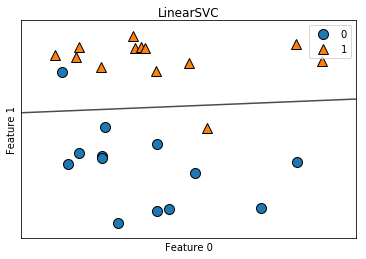

In [15]:
from sklearn.svm import LinearSVC

X, y = make_forge()
model = LinearSVC()
clf = model.fit(X,y)
plot_2d_separator(clf, X, fill=False, eps=0.5, alpha=.7)
discrete_scatter(X[:, 0], X[:, 1], y)
plt.title("{}".format(clf.__class__.__name__))
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")
plt.legend()

In this figure, we have the first feature of the dataset on the x-axis and the second feature on the y-axis. We display the decision boundary found by LinearSVC as a straight line, separating the area classified as class 1 on the top from the area classified as class 0 on the bottom. In other words, any new data point that lies above the black line will be classified as class 1 by the respective classifier, while any point that lies below the black line will be classified as class 0.

Note that the model misclassifies two of the points. By default, LinearSVC applies an L2 regularization, in the same way that Ridge does for regression.

For **LinearSVC** the trade-off parameter that determines the strength of the regularization is called **C**, and higher values of **C** correspond to less regularization. In other words, when you use a high value for the parameter **C**, LinearSVC tries to fit the training set as best as possible, while with low values of the parameter **C**, the model puts more emphasis on finding a coefficient vector (w) that is close to zero.

There is another interesting aspect of how the parameter **C** acts. Using low values of **C** will cause the algorithm to try to adjust to the “majority” of data points, while using a higher value of **C** stresses the importance that each individual data point be classified correctly. Here is an illustration:

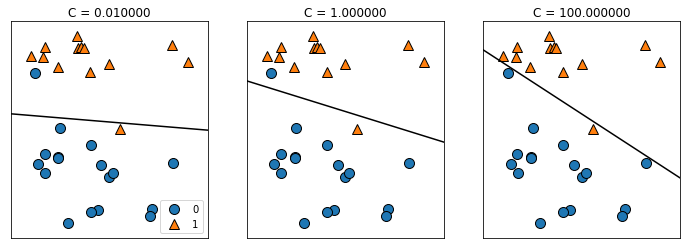

In [17]:
from sklearn.svm import SVC

def plot_linear_svc_regularization():
    X, y = make_blobs(centers=2, random_state=4, n_samples=30)
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    # a carefully hand-designed dataset lol
    y[7] = 0
    y[27] = 0
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5

    for ax, C in zip(axes, [1e-2, 1, 1e2]):
        discrete_scatter(X[:, 0], X[:, 1], y, ax=ax)

        svm = SVC(kernel='linear', C=C, tol=0.00001).fit(X, y)
        w = svm.coef_[0]
        a = -w[0] / w[1]
        xx = np.linspace(6, 13)
        yy = a * xx - (svm.intercept_[0]) / w[1]
        ax.plot(xx, yy, c='k')
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)
        ax.set_xticks(())
        ax.set_yticks(())
        ax.set_title("C = %f" % C)
    axes[0].legend(loc="best")
    
plot_linear_svc_regularization()

On the lefthand side, we have a very small **C** corresponding to a lot of regularization. Most of the points in class 0 are at the top, and most of the points in class 1 are at the bottom. The strongly regularized model chooses a relatively horizontal line, misclassifying two points. In the center plot, **C** is slightly higher, and the model focuses more on the two misclassified samples, tilting the decision boundary. Finally, on the righthand side, the very high value of **C** in the model tilts the decision boundary a lot, now correctly classifying all points in class 0. One of the points in class 1 is still misclassified, as it is not possible to correctly classify all points in this dataset using a straight line. The model illustrated on the righthand side tries hard to correctly classify all points, but might not capture the overall layout of the classes well. In other words, this model is likely overfitting.

Similarly to the case of regression, linear models for classification might seem very restrictive in low-dimensional spaces, only allowing for decision boundaries that are straight lines or planes. Again, in high dimensions, linear models for classification become very powerful, and guarding against overfitting becomes increasingly important when considering more features.

# Linear SVMs for multiclass classification
Many linear classification models are for binary classification only, and don’t extend naturally to the multiclass case (with the exception of logistic regression). A common technique to extend a binary classification algorithm to a multiclass classification algorithm is the one-vs.-rest approach. In the one-vs.-rest approach, a binary model is learned for each class that tries to separate that class from all of the other classes, resulting in as many binary models as there are classes. To make a prediction, all binary classifiers are run on a test point. The classifier that has the highest score on its single class “wins,” and this class label is returned as the prediction.

Having one binary classifier per class results in having one vector of coefficients (w) and one intercept (b) for each class. The class for which the result of the classification confidence formula given here is highest is the assigned class label:

    w[0] * x[0] + w[1] * x[1] + ... + w[p] * x[p] + b
The mathematics behind multiclass logistic regression differ somewhat from the one-vs.-rest approach, but they also result in one coefficient vector and intercept per class, and the same method of making a prediction is applied.

Let’s apply the one-vs.-rest method to a simple three-class classification dataset. We use a two-dimensional dataset, where each class is given by data sampled from a Gaussian distribution.

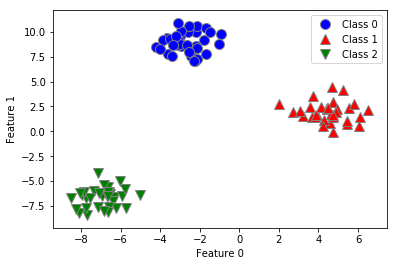

In [25]:
X, y = make_blobs(centers=3, random_state=42)
discrete_scatter(X[:, 0], X[:, 1], y, c=['b', 'r', 'g'])
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")
plt.legend(["Class 0", "Class 1", "Class 2"])

Now, we train a **LinearSVC** classifier on the dataset:

In [20]:
linear_svm = LinearSVC().fit(X, y)
print("Coefficient shape: ", linear_svm.coef_.shape)
print("Intercept shape: ", linear_svm.intercept_.shape)

Coefficient shape:  (3, 2)
Intercept shape:  (3,)


We see that the shape of the `coef_` is (3, 2), meaning that each row of `coef_` contains the coefficient vector for one of the three classes and each column holds the coefficient value for a specific feature (there are two in this dataset). The `intercept_` is now a one-dimensional array, storing the intercepts for each class.

Let’s visualize the lines given by the three binary classifiers:

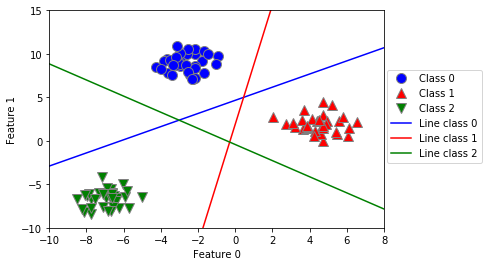

In [26]:
discrete_scatter(X[:, 0], X[:, 1], y, c=['b', 'r', 'g'])
line = np.linspace(-15, 15)
for coef, intercept, color in zip(linear_svm.coef_, linear_svm.intercept_, ['b', 'r', 'g']):
    plt.plot(line, -(line * coef[0] + intercept) / coef[1], c=color)
plt.ylim(-10, 15)
plt.xlim(-10, 8)
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")
plt.legend(['Class 0', 'Class 1', 'Class 2', 'Line class 0', 'Line class 1', 'Line class 2'], loc=(1.01, 0.3))

You can see that all the points belonging to class 0 in the training data are above the line corresponding to class 0, which means they are on the “class 0” side of this binary classifier. The points in class 0 are above the line corresponding to class 2, which means they are classified as “rest” by the binary classifier for class 2. The points belonging to class 0 are to the left of the line corresponding to class 1, which means the binary classifier for class 1 also classifies them as “rest.” Therefore, any point in this area will be classified as class 0 by the final classifier (the result of the classification confidence formula for classifier 0 is greater than zero, while it is smaller than zero for the other two classes).

But what about the triangle in the middle of the plot? All three binary classifiers classify points there as “rest.” Which class would a point there be assigned to? The answer is the one with the highest value for the classification formula: the class of the closest line.

The following example (Figure 2-21) shows the predictions for all regions of the 2D space: 

In [27]:
cm3 = ListedColormap(['#0000aa', '#ff2020', '#50ff50'])

def plot_2d_classification(classifier, X, fill=False, ax=None, eps=None, alpha=1, cm=cm3):
    # multiclass
    if eps is None:
        eps = X.std() / 2.

    if ax is None:
        ax = plt.gca()

    x_min, x_max = X[:, 0].min() - eps, X[:, 0].max() + eps
    y_min, y_max = X[:, 1].min() - eps, X[:, 1].max() + eps
    xx = np.linspace(x_min, x_max, 1000)
    yy = np.linspace(y_min, y_max, 1000)

    X1, X2 = np.meshgrid(xx, yy)
    X_grid = np.c_[X1.ravel(), X2.ravel()]
    decision_values = classifier.predict(X_grid)
    ax.imshow(decision_values.reshape(X1.shape), extent=(x_min, x_max,
                                                         y_min, y_max),
              aspect='auto', origin='lower', alpha=alpha, cmap=cm)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks(())
    ax.set_yticks(())

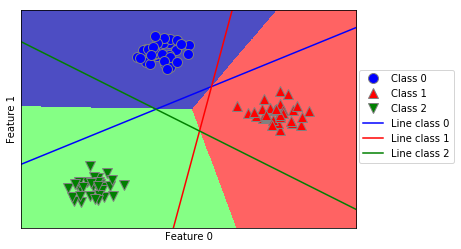

In [28]:
plot_2d_classification(linear_svm, X, fill=True, alpha=.7)
discrete_scatter(X[:, 0], X[:, 1], y, c=['b', 'r', 'g'])
line = np.linspace(-15, 15)
for coef, intercept, color in zip(linear_svm.coef_, linear_svm.intercept_, ['b', 'r', 'g']):
    plt.plot(line, -(line * coef[0] + intercept) / coef[1], c=color)
plt.legend(['Class 0', 'Class 1', 'Class 2', 'Line class 0', 'Line class 1', 'Line class 2'], loc=(1.01, 0.3))
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

## Kernelized Support Vector Machines
Kernelized support vector machines (often just referred to as SVMs) are an extension that allows for more complex models that are not defined simply by hyperplanes in the input space. While there are support vector machines for classification and regression, we will restrict ourselves to the classification case, as implemented in [SVC](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html). Similar concepts apply to support vector regression, as implemented in [SVR](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html).

The math behind kernelized support vector machines is a bit involved. You can find the details in Chapter 1 of Hastie, Tibshirani, and Friedman’s [The Elements of Statistical Learning](http://statweb.stanford.edu/~tibs/ElemStatLearn/).

### Linear models and nonlinear features
As you saw above, linear models can be quite limiting in low-dimensional spaces, as lines and hyperplanes have limited flexibility. One way to make a linear model more flexible is by adding more features—for example, by adding interactions or polynomials of the input features.

Let’s look at another synthetic dataset to help illustrate this:

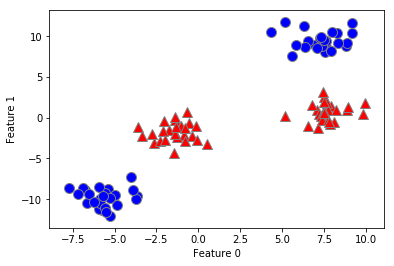

In [31]:
c=['b', 'r', 'g']
X, y = make_blobs(centers=4, random_state=8)
y = y % 2

discrete_scatter(X[:, 0], X[:, 1], y, c=c)
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

A linear model for classification can only separate points using a line, and will not be able to do a very good job on this dataset:

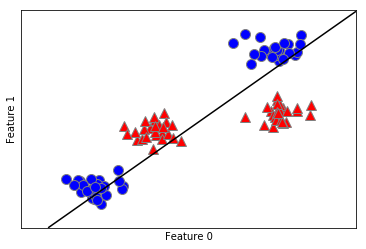

In [32]:
from sklearn.svm import LinearSVC
linear_svm = LinearSVC().fit(X, y)

plot_2d_separator(linear_svm, X)
discrete_scatter(X[:, 0], X[:, 1], y, c=c)
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

Now let’s expand the set of input features, say by also adding feature1^2, the square of the second feature, as a new feature. Instead of representing each data point as a two-dimensional point, (feature0, feature1), we now represent it as a three-dimensional point, (feature0, feature1, feature1^22). This new representation is illustrated below in a three-dimensional scatter plot:

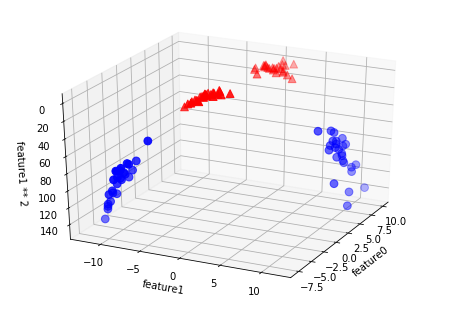

In [33]:
# add the squared first feature
X_new = np.hstack([X, X[:, 1:] ** 2])

from mpl_toolkits.mplot3d import Axes3D, axes3d
figure = plt.figure()
# visualize in 3D
ax = Axes3D(figure, elev=-152, azim=-26)
# plot first all the points with y == 0, then all with y == 1
mask = y == 0
ax.scatter(X_new[mask, 0], X_new[mask, 1], X_new[mask, 2], c='b', cmap=cm2, s=60)
ax.scatter(X_new[~mask, 0], X_new[~mask, 1], X_new[~mask, 2], c='r', marker='^', cmap=cm2, s=60)
ax.set_xlabel("feature0")
ax.set_ylabel("feature1")
ax.set_zlabel("feature1 ** 2")

In the new representation of the data, it is now indeed possible to separate the two classes using a linear model, a plane in three dimensions. We can confirm this by fitting a linear model to the augmented data:

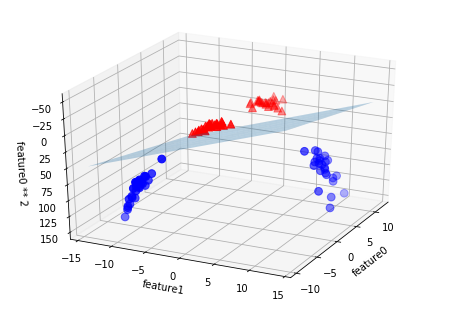

In [34]:
linear_svm_3d = LinearSVC().fit(X_new, y)
coef, intercept = linear_svm_3d.coef_.ravel(), linear_svm_3d.intercept_

# show linear decision boundary
figure = plt.figure()
ax = Axes3D(figure, elev=-152, azim=-26)
xx = np.linspace(X_new[:, 0].min() - 2, X_new[:, 0].max() + 2, 50)
yy = np.linspace(X_new[:, 1].min() - 2, X_new[:, 1].max() + 2, 50)

XX, YY = np.meshgrid(xx, yy)
ZZ = (coef[0] * XX + coef[1] * YY + intercept) / -coef[2]
ax.plot_surface(XX, YY, ZZ, rstride=8, cstride=8, alpha=0.3)
ax.scatter(X_new[mask, 0], X_new[mask, 1], X_new[mask, 2], c='b', cmap=cm2, s=60)
ax.scatter(X_new[~mask, 0], X_new[~mask, 1], X_new[~mask, 2], c='r', marker='^', cmap=cm2, s=60)

ax.set_xlabel("feature0")
ax.set_ylabel("feature1")
ax.set_zlabel("feature0 ** 2")

As a function of the original features, the linear SVM model is not actually linear anymore. It is not a line, but more of an ellipse, as you can see from the plot created here:

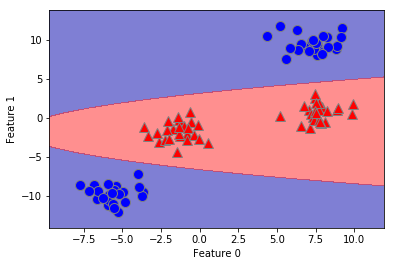

In [36]:
ZZ = YY ** 2
dec = linear_svm_3d.decision_function(np.c_[XX.ravel(), YY.ravel(), ZZ.ravel()])
plt.contourf(XX, YY, dec.reshape(XX.shape), levels=[dec.min(), 0, dec.max()], cmap=cm2, alpha=0.5)
discrete_scatter(X[:, 0], X[:, 1], y, c=c)
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

### The kernel trick
The lesson here is that adding nonlinear features to the representation of our data can make linear models much more powerful. However, often we don’t know which features to add, and adding many features (like all possible interactions in a 100-dimensional feature space) might make computation very expensive. Luckily, there is a clever mathematical trick that allows us to learn a classifier in a higher-dimensional space without actually computing the new, possibly very large representation. This is known as the *kernel trick*, and it works by directly computing the distance (more precisely, the scalar products) of the data points for the expanded feature representation, without ever actually computing the expansion.

There are two ways to map your data into a higher-dimensional space that are commonly used with support vector machines: the polynomial kernel, which computes all possible polynomials up to a certain degree of the original features (like feature1^2 x feature2^5); and the radial basis function (RBF) kernel, also known as the Gaussian kernel. The Gaussian kernel is a bit harder to explain, as it corresponds to an infinite-dimensional feature space. One way to explain the Gaussian kernel is that it considers all possible polynomials of all degrees, but the importance of the features decreases for higher degrees.

In practice, the mathematical details behind the kernel SVM are not that important, though, and how an SVM with an RBF kernel makes a decision can be summarized quite easily—we’ll do so in the next section.

### Understanding SVMs
During training, the SVM learns how important each of the training data points is to represent the decision boundary between the two classes. Typically only a subset of the training points matter for defining the decision boundary: the ones that lie on the border between the classes. These are called support vectors and give the support vector machine its name.

To make a prediction for a new point, the distance to each of the support vectors is measured. A classification decision is made based on the distances to the support vector, and the importance of the support vectors that was learned during training (stored in the `dual_coef_` attribute of **SVC**).

The distance between data points is measured by the Gaussian kernel:

    krbf(x1, x2) = exp (ɣǁx1 - x2ǁ2)
Here, x1 and x2 are data points, ǁ x1 - x2 ǁ denotes Euclidean distance, and ɣ (gamma) is a parameter that controls the width of the Gaussian kernel.

The figure below shows the result of training a support vector machine on a two-dimensional two-class dataset. The decision boundary is shown in black, and the support vectors are larger points with the wide outline. 

In [39]:
def make_handcrafted_dataset():
    # a carefully hand-designed dataset lol
    X, y = make_blobs(centers=2, random_state=4, n_samples=30)
    y[np.array([7, 27])] = 0
    mask = np.ones(len(X), dtype=np.bool)
    mask[np.array([0, 1, 5, 26])] = 0
    X, y = X[mask], y[mask]
    return X, y

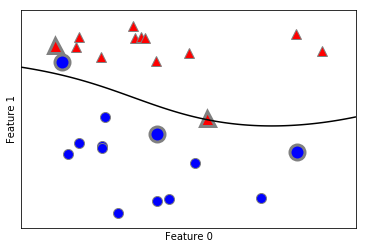

In [40]:
from sklearn.svm import SVC
X, y = make_handcrafted_dataset()
svm = SVC(kernel='rbf', C=10, gamma=0.1).fit(X, y)
plot_2d_separator(svm, X, eps=.5)
discrete_scatter(X[:, 0], X[:, 1], y, c=c)
# plot support vectors
sv = svm.support_vectors_
# class labels of support vectors are given by the sign of the dual coefficients
sv_labels = svm.dual_coef_.ravel() > 0
discrete_scatter(sv[:, 0], sv[:, 1], sv_labels, s=15, markeredgewidth=3, c=c)
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

In this case, the SVM yields a very smooth and nonlinear (not a straight line) boundary. We adjusted two parameters here: the **C** parameter and the **gamma** parameter, which we will now discuss in detail.

### Tuning SVM parameters
The **gamma** parameter is the one shown in the formula given in the previous section, which controls the width of the Gaussian kernel. It determines the scale of what it means for points to be close together. The **C** parameter is a regularization parameter, similar to that used in other models.  It limits the importance of each point (or more precisely, their `dual_coef_`).

Let’s have a look at what happens when we vary these parameters:

In [48]:
def plot_svm(log_C, log_gamma, ax=None):
    X, y = make_handcrafted_dataset()
    C = 10. ** log_C
    gamma = 10. ** log_gamma
    svm = SVC(kernel='rbf', C=C, gamma=gamma).fit(X, y)
    if ax is None:
        ax = plt.gca()
    plot_2d_separator(svm, X, ax=ax, eps=.5)
    # plot data
    discrete_scatter(X[:, 0], X[:, 1], y, ax=ax, c=c)
    # plot support vectors
    sv = svm.support_vectors_
    # class labels of support vectors are given by the sign of the dual coefficients
    sv_labels = svm.dual_coef_.ravel() > 0
    discrete_scatter(sv[:, 0], sv[:, 1], sv_labels, s=15, markeredgewidth=3, ax=ax, c=c)
    ax.set_title("C = %.4f gamma = %.4f" % (C, gamma))

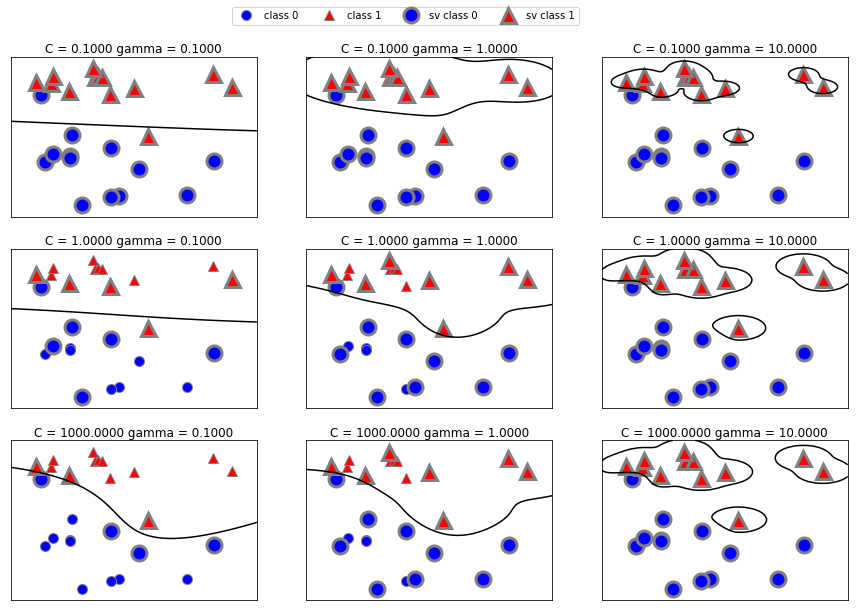

In [49]:
fig, axes = plt.subplots(3, 3, figsize=(15, 10))

for ax, C in zip(axes, [-1, 0, 3]):
    for a, gamma in zip(ax, range(-1, 2)):
        plot_svm(log_C=C, log_gamma=gamma, ax=a)

axes[0, 0].legend(["class 0", "class 1", "sv class 0", "sv class 1"], ncol=4, loc=(.9, 1.2))

Going from left to right, we increase the value of the parameter **gamma** from 0.1 to 10. A small **gamma** means a large radius for the Gaussian kernel, which means that many points are considered close by. This is reflected in very smooth decision boundaries on the left, and boundaries that focus more on single points further to the right. A low value of **gamma** means that the decision boundary will vary slowly, which yields a model of low complexity, while a high value of **gamma** yields a more complex model.

Going from top to bottom, we increase the **C** parameter from 0.1 to 1000. As with the linear models, a small **C** means a very restricted model, where each data point can only have very limited influence. You can see that at the top left the decision boundary looks nearly linear, with the misclassified points barely having any influence on the line. Increasing **C**, as shown on the bottom right, allows these points to have a stronger influence on the model and makes the decision boundary bend to correctly classify them.

Let’s apply the RBF kernel SVM to the Breast Cancer dataset. By default, **C**=1 and **gamma**=1/*n_features*:

In [52]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

cancer = load_breast_cancer()

X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state=0)

svc = SVC()
svc.fit(X_train, y_train)

print("Accuracy on training set: {:.2f}".format(svc.score(X_train, y_train)))
print("Accuracy on test set: {:.2f}".format(svc.score(X_test, y_test)))

Accuracy on training set: 1.00
Accuracy on test set: 0.63


The model overfits quite substantially, with a perfect score on the training set and only 63% accuracy on the test set. While SVMs often perform quite well, they are very sensitive to the settings of the parameters and to the scaling of the data. In particular, they require all the features to vary on a similar scale. Let’s look at the minimum and maximum values for each feature, plotted in log-space:

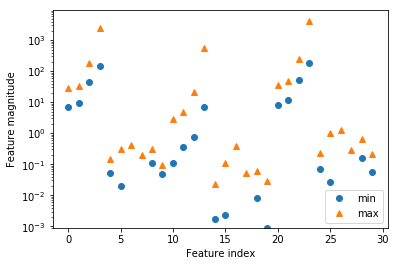

In [53]:
plt.plot(X_train.min(axis=0), 'o', label="min")
plt.plot(X_train.max(axis=0), '^', label="max")
plt.legend(loc=4)
plt.xlabel("Feature index")
plt.ylabel("Feature magnitude")
plt.yscale("log")

From this plot we can determine that features in the Breast Cancer dataset are of completely different orders of magnitude. This can be somewhat of a problem for other models (like linear models), but it has devastating effects for the kernel SVM. Let’s examine some ways to deal with this issue.

### Preprocessing data for SVMs
One way to resolve this problem is by rescaling each feature so that they are all approximately on the same scale. A common rescaling method for kernel SVMs is to scale the data such that all features are between 0 and 1. We will see how to do this using the MinMaxScaler preprocessing method:

In [54]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

svc = SVC()
svc.fit(X_train_scaled, y_train)

print("Accuracy on training set: {:.3f}".format(svc.score(X_train_scaled, y_train)))
print("Accuracy on test set: {:.3f}".format(svc.score(X_test_scaled, y_test)))

Accuracy on training set: 0.948
Accuracy on test set: 0.951


Scaling the data made a huge difference! Now we are actually in an underfitting regime, where training and test set performance are quite similar but less close to 100% accuracy. From here, we can try increasing either **C** or **gamma** to fit a more complex model. For example:

In [55]:
svc = SVC(C=1000)
svc.fit(X_train_scaled, y_train)

print("Accuracy on training set: {:.3f}".format(svc.score(X_train_scaled, y_train)))
print("Accuracy on test set: {:.3f}".format(svc.score(X_test_scaled, y_test)))

Accuracy on training set: 0.988
Accuracy on test set: 0.972


Here, increasing **C** allows us to improve the model significantly, resulting in 97.2% accuracy.

### Strengths, weaknesses, and parameters
Kernelized support vector machines are powerful models and perform well on a variety of datasets. SVMs allow for complex decision boundaries, even if the data has only a few features. They work well on low-dimensional and high-dimensional data (i.e., few and many features), but don’t scale very well with the number of samples. Running an SVM on data with up to 10,000 samples might work well, but working with datasets of size 100,000 or more can become challenging in terms of runtime and memory usage.

Another downside of SVMs is that they require careful preprocessing of the data and tuning of the parameters. This is why, these days, most people instead use tree-based models such as random forests or gradient boosting (which require little or no preprocessing) in many applications. Furthermore, SVM models are hard to inspect; it can be difficult to understand why a particular prediction was made, and it might be tricky to explain the model to a nonexpert.

Still, it might be worth trying SVMs, particularly if all of your features represent measurements in similar units (e.g., all are pixel intensities) and they are on similar scales.

The important parameters in kernel SVMs are the regularization parameter **C**, the choice of the **kernel**, and the kernel-specific parameters. Although we primarily focused on the RBF kernel, other choices are available in *scikit-learn*. The RBF kernel has only one parameter, **gamma**, which is the inverse of the width of the Gaussian kernel. **gamma** and **C** both control the complexity of the model, with large values in either resulting in a more complex model. Therefore, good settings for the two parameters are usually strongly correlated, and **C** and **gamma** should be adjusted together.